<font size="5">Run the ANUGA Model (BYOAM) </font>

<font size="3">In this notebook, we will:

- initiate the model with elevation, friction, stage
- set the boundary conditions
- run the model!



</font>

<font size="3">Before you can run this notebook, you should have run the 4_Build_ANUGA_Mesh</font>


## Get the names of the elevation file, mesh file, and coordinates for the tide and river boundaries from the previous notebooks

In [1]:
elev_name = 'Elevation_ocean-GEBCO_land-GLO30_rivers-wdpower_wetland-uni00m_lakes-uni1m_10'
mesh_name = 'Meshes_base_400000m2'
inletLAT =  1154623.0 
inletLON = 519136.0 
tideLAT = 1248551.1
tideLON = 547906.49  
tideLAT_4326 = 11.2943
tideLON_4326 = -74.5609 


<font size=5 color='green'> If you are running in Google Colab, set the variable yes_colab = True. If you are running on your own computer, set the variable yes_colab = False </font>


In [2]:
yes_colab = False

In [3]:
import sys
import os
from pathlib import Path
your_path = Path(os.getcwd())

<font size=5> Step #1: Mount Google Drive and Grant Access <font> <br>




<font size=3> When you run the next cell, a pop-up window will appear asking you to grant access to your Google Drive. You must approve or the notebook will not work. <font> <br>


In [4]:
import os
import sys
from pathlib import Path

your_path = Path(os.getcwd() + '/')
if yes_colab:
    where_to_mount = '/content/drive/'
    from google.colab import drive
    drive.mount(where_to_mount, force_remount=True)
    mounted_drive = Path(where_to_mount) / 'MyDrive' 
    sys.path.append(str(mounted_drive / 'installations'))
    path_ancillary = mounted_drive / 'ancillary'
    Path(mounted_drive / 'installations').mkdir(parents=True, exist_ok=True)

else:
    mounted_drive = Path('/Users/Alchrist/Documents/Github/BAM/')#Path(os.path.abspath(os.path.join(your_path, os.pardir)))

print('Your working directory is %s' %(mounted_drive))



Your working directory is /Users/Alchrist/Documents/Github/BAM


<font size=5> Step #2: Install packages. <font> <br>
<font size=3> This cell should install all Python packages you need for each tutorial.<font>

In [5]:
import os
os.chdir(mounted_drive)
if yes_colab:
  if os.path.isdir(mounted_drive / 'BAM'):
    print('## Updating the local git repository \n')
    os.chdir(mounted_drive / 'BAM')
    #!git fsck --full
    # !git add -A 
    !git stash   
    !git pull
    # !rm -rf {mounted_drive/'BAM'}

  else:
    print('## Pulling the git repository with files for the tutorial\n')
    !git clone https://github.com/achri19/BAM.git


In [6]:
print(mounted_drive)

/Users/Alchrist/Documents/Github/BAM


<font size=5> Step #3: Set up working directories<font> 


<font size=3> We will access data files stored on a shared Google Drive. You will also need to save files to your own Google Drive.<font>



In [7]:
path_ancillary = mounted_drive / 'ancillary'
path_code = mounted_drive / 'scripts'
path_templates = mounted_drive /  'templates'
path_configs = mounted_drive / 'configs'
path_notebooks = mounted_drive / 'notebooks'
sys.path.insert(1,str(path_code))
print(path_code)

path_examples = mounted_drive / 'examples'
Path(path_examples).mkdir(parents=True, exist_ok=True)

/Users/Alchrist/Documents/Github/BAM/scripts


In [8]:
## All necessary files are zipped here
demo = False
if demo:
    !unzip -n $path_notebooks/komo.zip -d $path_examples 
    AOI = 'komo'
## !unzip -n komo_estuary_tutorial/komo_starter.zip -d $mounted_drive 
else:
    AOI = 'magdalena'

<font size=5> Step #4: Now we will import Python packages, which will be used for future tutorials. If there are any errors, try rerunning the first cell <font> 




In [9]:
# Standard packages
import os
import time
import sys
import fnmatch
import numpy as np
import scipy
import scipy.interpolate
import pandas as pd
from datetime import datetime
from string import Template
import geopandas as gpd
from shapely.geometry import Polygon, Point
import rasterio
from pathlib import Path
from shapely.geometry import LineString
from osgeo import gdal

## ANUGA packages
import anuga
from anuga.utilities.plot_utils import Make_Geotif
from anuga.coordinate_transforms.geo_reference import Geo_reference
from anuga.utilities import animate
from anuga import myid, numprocs, finalize, barrier, Inlet_operator

## Plotting modules
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

#mpl.rcParams['animation.ffmpeg_path'] = r'/Users/alchrist/Downloads/ffmpeg'
## If you get an error with producing animation plots, uncomment the line above and add directory for ffmpeg (r'/PATH/TO/ffmpeg')
import matplotlib.animation as animation
writer = animation.FFMpegWriter(fps=60)



In [10]:
try:
  import pyTMD
except:
  !pip install pytmd

from main_tools import (build_directory,
                       get_extent_parameters,
                       setup_AOI_files, 
                       make_polygons,
                       make_channel_networks,
                       make_model_foundation, 
                       set_boundary_conditions, 
                       make_watermask,
                       more_opening)


/Users/Alchrist/Documents/Github/BAM/scripts/orinoco_tools.py:42: UserWarning: ShapelyDeprecationWarning
  warnings.warn('ShapelyDeprecationWarning')
/Users/Alchrist/Documents/Github/BAM/scripts/orinoco_tools.py:43: UserWarning: UserWarning
  warnings.warn('UserWarning')


<font size= 5 color = 'red'> Copy the AOI and elevationpath from the previous notebook into the cell below:

In [11]:


Path((path_examples / AOI)).mkdir(parents=True, exist_ok=True)

skip = False
res = 10 #meters
print('\n')
print('Study area is ' + AOI)
print('Resolution of this setup is %sm' %(res))

working_path,folders = build_directory(path_examples, AOI)
working_path = Path(working_path)
print(working_path)





Study area is magdalena
Resolution of this setup is 10m



##############################################################################################
################################[Step 1][Build Directory]#####################################
##############################################################################################

##################### The working directory set as: 

/Users/Alchrist/Documents/Github/BAM/examples/magdalena
 
##################### Folders are:
##################### 0 User_Defined_Files --> User shapefile of model domain and water mask
##################### 1 tmp --> For temporary files
##################### 3 Meshes --> Where we will build model meshes
##################### 4 DEMs --> Where we will build digital elevation models
##################### 5 Boundaries --> Where we will store boundary files
##################### 6 Simulations --> Where we will run simulations
##################### 7 Setup_Files/Setup_SHP --> Shapefiles for setup 

<font size= 5 color = 'red'> Copy the AOI and elevationpath from the previous notebook into the cell below:

<font size=3> Give the name of your study area, must be the same in all notebooks </font>


In [12]:
print('DEM = %s' %(elev_name))

print('MESH = %s' %(mesh_name))

boundary_types = ('Br','Bout')

DEM = Elevation_ocean-GEBCO_land-GLO30_rivers-wdpower_wetland-uni00m_lakes-uni1m_10
MESH = Meshes_base_400000m2


In [13]:
tide_data = np.genfromtxt(folders[5]/ ('Tide_LAT%s_LON%s' %(np.round(tideLAT_4326,4),np.round(tideLON_4326+360,4))) / ('magdalena_tides_lat%s_lon%s_20100101.csv' %(np.round(tideLAT_4326,2),np.round(tideLON_4326+360,2))),delimiter=',')


In [14]:
parameters = pd.read_csv('%s/%s_Configuration.csv' %(folders[2],AOI))

EPSG = int(parameters['EPSG'])
landcovermethod = parameters['LandcoverMethod'][0]
discharge = 300

print(parameters.iloc[0] )

Unnamed: 0.1                                  0
Unnamed: 0                                    0
AOI                                   Magdalena
area_m2                           11200000000.0
perimeter_m                           423526.36
RiverOceanBoundary                          0.0
Discharge                                2000.0
ExtentFile                  Magdalena_input.shp
LandcoverMethod                      WorldCover
LandElevMethod                            GLO30
OceanElevMethod                           GEBCO
LowerRiverElevMethod                      plane
UpperRiverElevMethod                    wdpower
WetlandElevMethod                    constant_0
LakeElevMethod                       constant_1
ManningLUT                              default
WetlandClass                               90.0
BEDINTERCEPT_lower                      0.00004
BEDSLOPE_lower                         0.000006
BEDINTERCEPT_upper                      0.00004
BEDSLOPE_upper                         0

/var/folders/29/4c92_fhn3_g9d625mvc8mrth0000gq/T/ipykernel_67234/3846138830.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  EPSG = int(parameters['EPSG'])


In [15]:
now = datetime.now()
startdate = '20240401'
enddate = '20240430'
simu_length    = (datetime.strptime(enddate,'%Y%m%d')-datetime.strptime(startdate,'%Y%m%d')).days


In [16]:
scenario = 'Test2'
print(scenario)
modelpath = folders[6] / scenario
print(modelpath)

Path((folders[6] / scenario)).mkdir(parents=True, exist_ok=True)
os.chdir(modelpath)



Test2
/Users/Alchrist/Documents/Github/BAM/examples/magdalena/Simulations/Test2


In [17]:
from rasterio.mask import mask
AOI_extent = gpd.read_file(folders[7] / ('%s_extent_%s.shp' %(AOI,EPSG)))
watermask = rasterio.open(folders[8] / ('%s_watermask_%s.tif' %(AOI,res)))
masked, mask_transform = mask(dataset=watermask,shapes=AOI_extent.geometry,crop=False)
masked = np.where(masked==-9999,np.nan,masked)

origin_x = watermask.profile['transform'][2]
origin_y = watermask.profile['transform'][5]


In [18]:
AOI_extent.geometry[0].wkt


'POLYGON ((498950 1250269, 598890 1250269, 598890 1134219, 498950 1134219, 498950 1250269))'

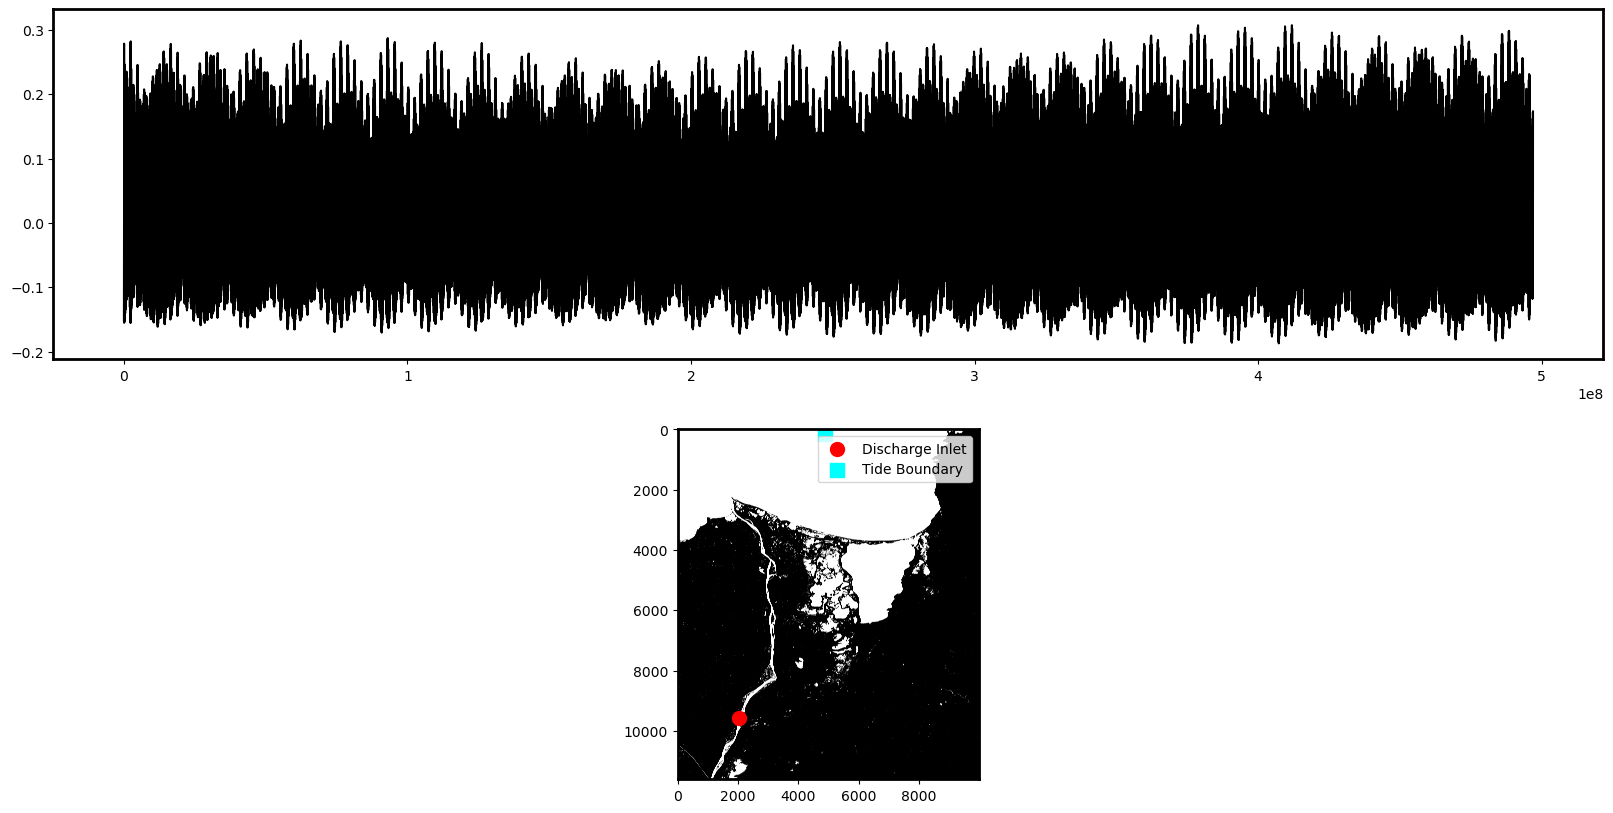

In [19]:
fig,[ax2,ax3] = plt.subplots(nrows=2,figsize=(20,10))

ax2.plot(tide_data[:,0],tide_data[:,1],'black')

ax3.imshow(masked[0],'gray')
ax3.scatter((inletLON-origin_x)/res,(origin_y - inletLAT)/res, s=100, c='red', marker='o',label='Discharge Inlet')
ax3.scatter((tideLON-origin_x)/res,(origin_y - tideLAT)/res, s=100, c='cyan', marker='s',label='Tide Boundary')
ax3.legend()

# plt.savefig(folders[5] / ('%s_model_boundaries_TideLAT%s_TideLON%s_InletLAT%s_InletLON%s.png' %(AOI,tideLAT,tideLON,inletLAT,inletLON)),bbox_inches='tight')

In [20]:
geo_reference = Geo_reference(zone=EPSG,
                                datum='wgs84',
                                projection='UTM',
                                false_easting=500000,
                                false_northing=0)
# boundaryPolygon = [ [0., 0.], [0., 100.], [100.0, 100.0], [100.0, 0.0]]
# bounding_polygon = [[498950, 1134219], [498950, 1250269], [598890, 1250269], [598890, 1134219]]
# domain = anuga.create_domain_from_regions(
#             bounding_polygon,
#             boundary_tags={'South': [0],
#                            'East':  [1],
#                            'North':    [2],
#                            'West':   [3]},
#             maximum_triangle_area=400000)
domain = anuga.create_domain_from_file(str(folders[3]/mesh_name/ (mesh_name + '.tsh')))
domain.set_name(scenario) # Name of sww file
domain.set_datadir(str(modelpath))
domain.set_low_froude(1)
domain.set_flow_algorithm('DE1')
domain.set_minimum_allowed_height(0.02)
domain.report_water_volume_statistics
#print(domain.statistics())
domain.store_centroids = True
##############################################################################
##############################################################################

dplotter = animate.Domain_plotter(domain,plot_dir = str(modelpath / 'plot'))


Figure files for each frame will be stored in /Users/Alchrist/Documents/Github/BAM/examples/magdalena/Simulations/Test2/plot


<font size=5 color='red'> Apply the DEM to the model domain </font>

/Users/alchrist/anaconda3/envs/BAM_dev/lib/python3.10/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


################################# Elevation made with:     magdalena_Elevation_ocean-GEBCO_land-GLO30_rivers-wdpower_wetland-uni00m_lakes-uni1m_10.asc


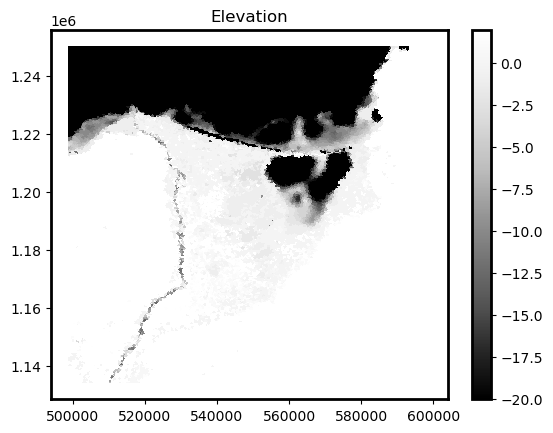

In [21]:
## Bed elevation

gdal.Translate(str(folders[4]/elev_name) + '.asc', str(folders[4]/elev_name) + '.tif', format='AAIGrid',noData =-9999)
domain.set_quantity('elevation', filename= str(folders[4]/elev_name) + '.asc', location = 'centroids')
print('################################# Elevation made with:     %s_%s.asc' %(AOI,elev_name))
plt.tripcolor(dplotter.triang, 
              facecolors = dplotter.elev, 
              cmap='Greys_r',vmin=-20,vmax=2)
plt.colorbar();
plt.title("Elevation");
plt.savefig(modelpath / 'plot'/ ('Elevation%s.png' %(myid)))


<font size=5 color='red'> Apply the Manning coefficients to the model domain </font>

In [22]:
## Manning roughness

gdal.Translate(str(folders[8] / ('%s_manning.asc' %(AOI))), str(folders[8] / ('%s_manning_%s.tif' %(AOI,landcovermethod))),format='AAIGrid',noData=-9999)
domain.set_quantity('friction', filename= str(folders[8] / ('%s_manning.asc' %(AOI))), location='centroids')        # Constant friction
print('################################# Friction set with:      %s_manning.asc' %(AOI))


################################# Friction set with:      magdalena_manning.asc


<font size=5 color='red'> Set an initial water level on top of the model </font>

################################# Initial stage set with at -0.1m


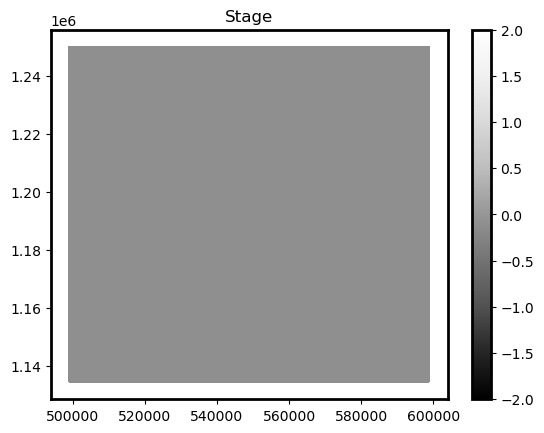

In [23]:
## Stage
domain.set_quantity('stage', -0.1,location='centroids')
print('################################# Initial stage set with at -0.1m')

plt.tripcolor(dplotter.triang, 
              facecolors = dplotter.stage, 
              cmap='Greys_r',vmin=-2,vmax=2)
plt.colorbar();
plt.title("Stage");

<font size=5 color='red'> Make some plots </font>

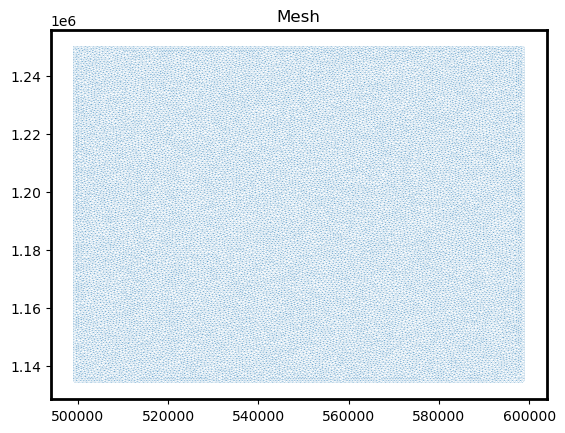

In [24]:

plt.triplot(dplotter.triang,linewidth=0.1)
plt.title("Mesh")
plt.savefig(modelpath / 'plot'/ ('mesh%s.png' %(myid)))


In [25]:
domain.print_algorithm_parameters()


#============================
# Domain Algorithm Parameters 
#============================
{   'CFL': 1.0,
    'alpha_balance': 2.0,
    'compute_fluxes_method': 'DE',
    'distribute_to_vertices_and_edges_method': 'DE',
    'extrapolate_velocity_second_order': True,
    'flow_algorithm': 'DE1',
    'g': 9.8,
    'low_froude': 0,
    'maximum_allowed_speed': 0.0,
    'minimum_allowed_height': 0.02,
    'minimum_storable_height': 0.001,
    'optimise_dry_cells': False,
    'optimised_gradient_limiter': True,
    'tight_slope_limiters': True,
    'timestepping_method': 'rk2',
    'use_centroid_velocities': True,
    'use_edge_limiter': True,
    'use_sloped_mannings': False}
#----------------------------


In [26]:

print (domain.statistics())

------------------------------------------------
Mesh statistics:
  Number of triangles = 44813
  Extent [m]:
    x in [4.98950e+05, 5.98890e+05]
    y in [1.13422e+06, 1.25027e+06]
  Areas [m^2]:
    A in [1.32222e+05, 3.99982e+05]
    number of distinct areas: 44813
    Histogram:
      [1.32222e+05, 1.58998e+05[: 911
      [1.58998e+05, 1.85774e+05[: 4004
      [1.85774e+05, 2.12550e+05[: 7013
      [2.12550e+05, 2.39326e+05[: 7269
      [2.39326e+05, 2.66102e+05[: 6341
      [2.66102e+05, 2.92878e+05[: 5815
      [2.92878e+05, 3.19654e+05[: 5082
      [3.19654e+05, 3.46430e+05[: 3957
      [3.46430e+05, 3.73206e+05[: 2791
      [3.73206e+05, 3.99982e+05]: 1630
    Percentiles (10 percent):
      4481 triangles in [1.32222e+05, 1.83845e+05]
      4481 triangles in [1.83845e+05, 2.01591e+05]
      4481 triangles in [2.01591e+05, 2.17552e+05]
      4481 triangles in [2.17552e+05, 2.34163e+05]
      4481 triangles in [2.34163e+05, 2.53421e+05]
      4481 triangles in [2.53421e+05, 2.71

<font size=5 color='red'> Set tidal boundary and apply tide data </font>

In [27]:
start_tides = (datetime.strptime(startdate,'%Y%m%d') - datetime.strptime('20100101','%Y%m%d')).days * 24 +1
end_tides = start_tides + (simu_length) * 24 +1
stage_time_fun = scipy.interpolate.interp1d(
    tide_data[:simu_length*24+1, 0],
    tide_data[start_tides:end_tides, 1])



In [28]:
domain.set_boundary({'West': anuga.Reflective_boundary(domain), 
                     'East': anuga.Reflective_boundary(domain), 
                     'South': anuga.Reflective_boundary(domain), 
                     'North': anuga.Time_boundary(domain,function=lambda t: [stage_time_fun(t),0.0,0.0])})

################################# Boundaries set as: 
North: Bout
East: Br
South: Br
West: Br


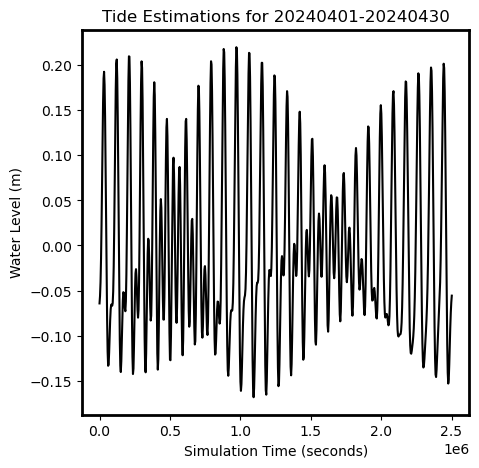

In [29]:
fig = plt.figure(figsize = (5,5), facecolor = 'w', edgecolor = 'k')
plt.plot(tide_data[:simu_length*24, 0], stage_time_fun(tide_data[:simu_length*24, 0]), color = 'black')
plt.xlabel("Simulation Time (seconds)")
plt.ylabel("Water Level (m)")
plt.title("Tide Estimations for %s-%s" %(startdate,enddate))
plt.savefig(modelpath / 'plot' / ('%s_tides.png' %(AOI)))

print('################################# Boundaries set as: \nNorth: %s\nEast: %s\nSouth: %s\nWest: %s' %('Bout','Br','Br','Br'))


<font size=5 color='red'> Set a point of discharge and set the steady state discharge value (m3/s)</font>

In [30]:
## Set upstream discharge boundary
center = (inletLON,inletLAT)
radius = 5000
fixed_inflow = None


In [31]:
line0 = [[center[0],center[1]],[center[0]-5,center[1]]]
fixed_inflow = Inlet_operator(domain,line0,Q=discharge,logging=True, description='upstream river', verbose = True)
if fixed_inflow is not None:
    print('################################# Discharge of %s m^3/s is input at (%s,%s)' %(discharge,center[0],center[1]))
    fixed_inflow.print_statistics()


P0 has 1 triangles in region line
Parallel Inlet Operator =================
Poly = line
Master Processor is P0
Processors are P[0]
################################# Discharge of 300 m^3/s is input at (519136.0,1154623.0)
Parallel Inlet Operator: inlet_1_P0
Description
upstream river
Inlet
======> inlet triangle indices and centres and elevation at P0
[26152]
[[ 519180.19304868 1154838.41578715]]
[-4.32363763]

Enquiry point:line
True



<font size=5 color='red'> Start the simulation! </font>

In [ ]:
startnow = datetime.now()
print('################################# Starting Simulation at %s' %(startnow.strftime("%d/%m/%Y %H:%M:%S")))
print('################################# Simulation will run from %s to %s' %(startdate, enddate))
print('################################# Simulation length will be %s days, %s seconds' %(simu_length,simu_length*24*60*60))
print('################################# SWW file will be: ' + scenario )# Evolve system through time

sys.stdout.flush()

#------------------------------------------------------------------------------
for t in domain.evolve(yieldstep=3600, duration=(simu_length*24*60*60)):
    print(t)
    domain.print_timestepping_statistics()
    print(domain.volumetric_balance_statistics())
    # print(domain.report_water_volume_statistics())
    
    #domain.report_water_volume_statistics()
    dplotter.save_stage_frame(vmin=-1, vmax=2.0)
    sys.stdout.flush()

endnow = datetime.now()
print('################################# Completed Simulation at %s' %(endnow.strftime("%d/%m/%Y %H:%M:%S")))

anuga.finalize()

################################# Starting Simulation at 24/05/2024 09:35:59
################################# Simulation will run from 20240401 to 20240430
################################# Simulation length will be 29 days, 2505600 seconds
################################# SWW file will be: Test2
0.0
Time = 0.0000 (sec), steps=0 (157s)
---------------------------
Volumetric balance report:
Note: Boundary fluxes are not exact
See get_boundary_flux_integral for exact computation
--------------------------
Total boundary inflow [m^3/s]: 0.00
Total boundary outflow [m^3/s]: 0.00
Net boundary flow by tags [m^3/s]
    West [m^3/s]: 0.00
    North [m^3/s]: 0.00
    East [m^3/s]: 0.00
    South [m^3/s]: 0.00
Total net boundary flow [m^3/s]: 0.00
Total volume in domain [m^3]: 877244126511.97

3600.0
Time = 3600.0000 (sec), delta t in [0.97502931, 0.97504626] (s), steps=3693 (78s)
---------------------------
Volumetric balance report:
Note: Boundary fluxes are not exact
See get_boundary_flux_i

In [ ]:
print(domain.report_water_volume_statistics())


<font size=5 color='red'> Done running the model. Move on to the next notebook 6_Post_Process.ipynb </font>


<font size=3 > Computation time depends on your computer. For mine, 900s (15 minute) of simulation required 26s of real time. The full simulation (48 hours), required 1 hour and 20 minutes. </font>

In [ ]:
print(scenario)
print(modelpath)